## Forecasting - Egypt

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/derekmcadam/opt/an

In [2]:
# reading in data
df = pd.read_csv('data/conflict-clusters.csv')

In [4]:
# pulling events in Egypt
data = df.loc[df['country'] == 'Egypt', :]

In [6]:
data.shape

(1719, 58)

In [7]:
# dropping columns not necessary for modeling
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

/Users/derekmcadam/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
# calculating weekly count of events for dataframe
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [10]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [11]:
# merging data and weekly count
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [13]:
data.set_index('event_date', inplace=True)

In [14]:
data.drop(columns='date', inplace=True)

In [15]:
# dummying first adminstrative location
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,count,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians,admin1_Alexandria,admin1_Assiut,admin1_Aswan,admin1_Behera,admin1_Beni Suef,admin1_Cairo,admin1_Dakahlia,admin1_Damietta,admin1_Fayoum,admin1_Gharbia,admin1_Giza,admin1_Ismailia,admin1_Kafr El-Shikh,admin1_Kalyoubia,admin1_Luxor,admin1_Matrouh,admin1_Menia,admin1_Menoufia,admin1_New Valley,admin1_North Sinai,admin1_Port Said,admin1_Qena,admin1_Red Sea,admin1_Sharkia,admin1_South Sinai,admin1_Suez,admin1_Suhag
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,29.9667,31.2500,1,0,564,56,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,30.0488,31.2343,1,0,654,54,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,24.0911,32.8973,1,0,654,54,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,3,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,29.3570,30.6437,1,1,598,59,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,29.9464,30.9169,1,1,508,59,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29,30.0771,31.2859,2,0,750,55,12,0.0,16.0819,10.76,-0.475,-0.60,-0.57,-0.865,-1.265,-1.29,35,6,6,3,5,5,101.03,37,29,66,52,71.74,88.4,8.2,8.6,4.3,10.0,6.7,31.96,48.12,42.705,98.0,0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-30,31.1316,33.7984,1,1,727,54,12,0.0,16.0819,10.76,-0.475,-0.60,-0.57,-0.865,-1.265,-1.29,35,6,6,3,5,5,101.03,37,29,66,52,71.74,88.4,8.2,8.6,4.3,10.0,6.7,31.96,48.12,42.705,98.0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2019-12-30,31.2160,34.

In [16]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [17]:
y = data['count']
X = data.drop(columns=['count'])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
# Normalizing numeric data
minmax = MinMaxScaler()

In [20]:
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [21]:
X_train.shape

(1289, 39)

In [22]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [23]:
batch_x, batch_y = train[0]

In [24]:
batch_x.shape

(64, 3, 39)

In [25]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.7))
# Second LSTM layer
model.add(LSTM(units=64, kernel_regularizer=regularizers.l1(1e-5),activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# Third LSTM layer
model.add(LSTM(units=64, kernel_regularizer=regularizers.l1(1e-5),activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 64)             26624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 64)             0         
________________________________________________

In [26]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
21/21 [==============================] - 1s 48ms/step - loss: 93.4785 - val_loss: 92.4342
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 64.7613 - val_loss: 85.0149
Epoch 3/20
21/21 [==============================] - 0s 7ms/step - loss: 56.9071 - val_loss: 75.4218
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 53.8930 - val_loss: 74.7771
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 54.3881 - val_loss: 71.7020
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 53.5498 - val_loss: 64.9955
Epoch 7/20
21/21 [==============================] - 0s 7ms/step - loss: 52.2467 - val_loss: 66.3620
Epoch 8/20
21/21 [==============================] - 0s 7ms/step - loss: 52.7309 - val_loss: 63.2518
Epoch 9/20
21/21 [==============================] - 0s 7ms/step - loss: 52.4033 - val_loss: 62.7358
Epoch 10/20
21/21 [==============================] 

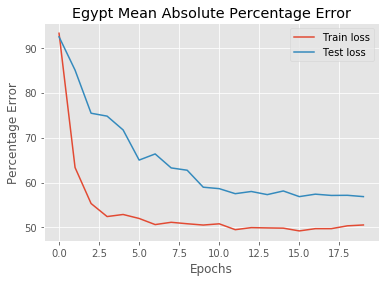

In [27]:

plt.style.use('ggplot')
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.title('Egypt Mean Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('Percentage Error')
plt.legend()
plt.savefig('imgs/egyptloss.jpeg');

In [28]:
egypt_preds = model.predict(test)

In [42]:
def plot_predictions(test, predicted):
    plt.gcf()
    plt.plot(test, label='True Values')
    plt.plot(predicted, label='Predicted Values')
    plt.title('Egypt Forecast')
    plt.xlabel('Time')
    plt.ylabel('Weekly Count of Events')
    plt.legend()
    plt.savefig('imgs/forecast-egypt.jpeg')
    plt.show();

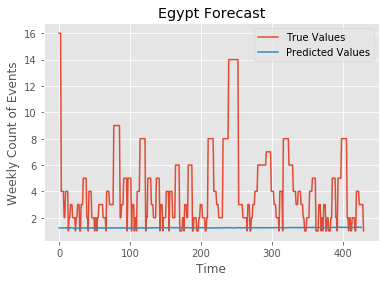

In [43]:
plot_predictions(y_test.values, egypt_preds);